# Gotland Basin

This notebook plots the time series of the surface forcing and simulated sea surface temperature and mixed layer depth in the [Gotland deep](https://gotm.net/cases/gotland_deep/) test case. 

In [1]:
import sys
import numpy as np
import string
import matplotlib.pyplot as plt
# add the path of gotmtool
sys.path.append("../gotmtool")
from gotmtool import *
from gotmtool.diags import get_mld_deltaT

## Load data

First, store the information of the four simulations into lists and dictionaries. 

In [2]:
casenames = [
    'GLS-C01A',
    'KPP-CVMix',
    'KPPLT-VR12',
    'KPPLT-LF17',
    ]

colors = {
    'GLS-C01A': 'tab:blue',
    'KPP-CVMix': 'tab:olive',
    'KPPLT-VR12': 'tab:orange',
    'KPPLT-LF17': 'tab:red',
    }

casedir = '../gotm/run/Gotland_wave'
save_fig = True

Get the time when observation is available.

In [3]:
with open('gotland_obs_time.txt', 'r') as file:
    time_str = file.read().replace('/','-')
    
obs_time_str_list = time_str.split('\n')[:-1]
obs_time_list = [np.datetime64(ts) for ts in obs_time_str_list]

Load data into a dictionary.

In [4]:
sims = {}
dataset = {}
for case in casenames:
    sim = Simulation(path=casedir+'/'+case)
    sims[case] = sims
    dataset[case] = sim.load_data()

## Figure

Time series of (a) net surface heat flux (W m$^{-2}$), (b) surface friction velocity (m s$^{-1}$), (c) La$_t^{-2}$ where La$_t$ is the turbulent Langmuir number, (d) sea surface temperature (SST; $^\circ$C), and (e) mixed layer depth (MLD; m) defined by a 0.2 $^\circ$C temperature threshold referenced to the surface.

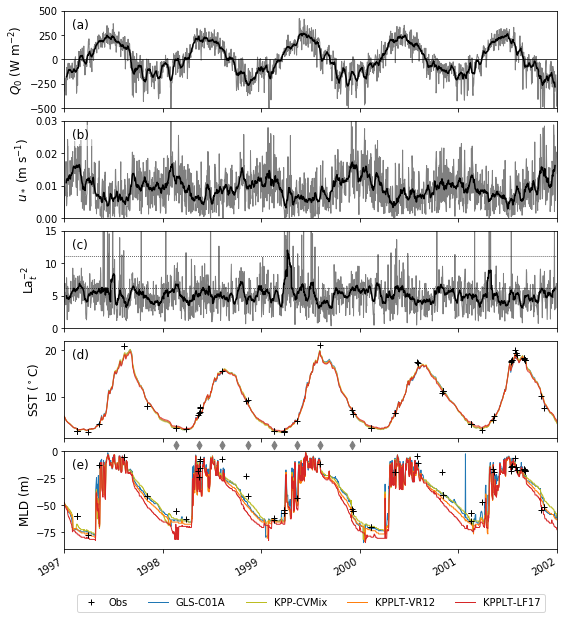

In [5]:
fig, axarr = plt.subplots(5,sharex='col')
fig.set_size_inches([8,9])

rho_w = 1000.
data    = dataset['KPP-CVMix']
ustar   = data.u_taus
laturb  = data.La_Turb
laturb  = laturb.where(laturb < 1.e3, drop=True)
heat    = data.heat
I0      = data.int_swr.diff(dim='time')/86400
tflux   = heat + I0
time    = data.time
time_start = time[0]
time_end = time[-1]

tflux.plot(ax=axarr[0], color='gray', linewidth=1)
tflux.rolling(time=15, center=True).mean().plot(
    ax=axarr[0], color='k', linewidth=1.5)
ustar.plot(ax=axarr[1], color='gray', linewidth=1)
ustar.rolling(time=15, center=True).mean().plot(
    ax=axarr[1], color='k', linewidth=1.5)
(laturb**(-2)).plot(ax=axarr[2], color='gray', linewidth=1)
(laturb**(-2)).rolling(time=15, center=True).mean().plot(
ax=axarr[2], color='k', linewidth=1.5)

pfllist = []
for t in obs_time_list:
    if t > time_start and t < time_end:
        pfllist.append(t)
tidxlist = [10, 14, 18, 20, 21, 27, 28, 29]

for tidx in tidxlist:
    axarr[4].scatter(pfllist[tidx], 6, color='gray', marker='d', clip_on=False)

data.temp_obs[-1,:,0,0].sel(time=pfllist, method='nearest').plot(
    color='k', marker='+', linestyle='none', ax=axarr[3], label='Obs', zorder=3)
mld_obs = -get_mld_deltaT(data.temp_obs[:,:,0,0], zRef=0.)
mld_obs.sel(time=pfllist, method='nearest').plot(
    color='k', marker='+', linestyle='none', ax=axarr[4], label='Obs', zorder=3)

for case in casenames:
    temp = dataset[case].temp
    temp[-1,:,0,0].rolling(time=1, center=True).mean().plot(
        ax=axarr[3], color=colors[case], linewidth=1, alpha=0.8, label=case)

    mld = -get_mld_deltaT(temp[:,:,0,0], zRef=0.)
    mld = mld.where(mld.values>-240.)
    mld.rolling(time=1, center=True).mean().plot(
        ax=axarr[4], color=colors[case], linewidth=1,label=case)

axarr[4].legend(loc = 'lower center', fontsize=10, ncol=5,
                  bbox_to_anchor=(0.5, -0.7))

axarr[0].set_ylabel('$Q_0$ (W m$^{-2}$)', fontsize=12)
axarr[0].axhline(0, color='k', linewidth=0.75)
axarr[0].set_ylim([-500, 500])
axarr[1].set_ylabel('$u_*$ (m s$^{-1}$)', fontsize=12)
axarr[1].set_ylim([0, 0.03])
axarr[2].axhline(0.3**(-2), color='k', linestyle=':', linewidth=0.75)
axarr[2].axhline(0.4**(-2), color='k', linestyle=':', linewidth=0.75)
axarr[2].set_ylim([0, 15])
axarr[2].set_ylabel('La$_t^{-2}$', fontsize=12)
axarr[3].set_ylabel('SST ($^\circ$C)', fontsize=12)
axarr[3].set_ylim([1, 22])
axarr[4].set_ylim([-90, 0])
axarr[4].set_ylabel('MLD (m)', fontsize=12)

for i, ax in enumerate(axarr):
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_xlim([time_start,time_end])
    ax.text(0.015, 0.92, '('+string.ascii_lowercase[i]+')', transform=ax.transAxes,
            bbox=dict(facecolor='w', edgecolor='none', alpha=0.5),
            fontsize=12, va='top')
    
if save_fig:
    plt.subplots_adjust(top=0.95, bottom=0.12, right=0.98, hspace=0.13)
    figname = 'gotland_wave_ts.pdf'
    fig.savefig(figname, dpi=300)